<a href="https://colab.research.google.com/github/ola-sumbo/Hamoye-and-ML-with-Ude/blob/master/Stage_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import numpy as np

In [6]:
df = read_csv('https://raw.githubusercontent.com/rahatUlAin/Electrical-Grid-Stability-Simulated-Data-/master/Data_for_UCI_named.csv')
df.head()
df.shape

(10000, 14)

In [13]:
df = pd.get_dummies(df)
df.columns

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'stabf_stable', 'stabf_unstable'],
      dtype='object')

In [8]:
#check distribution of target variable
df['stabf'].value_counts()
df['stab'].value_counts()

#checking for null values in the dataset
df.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [20]:
X = df[['tau1', 'tau2', 'tau3', 'tau4', 'p2', 'p3', 'p4', 'g1', 'g2','g3', 'g4']].values
y = df[['stabf_stable']].values.flatten()

array([0, 1, 0, ..., 1, 0, 0], dtype=uint8)

**Data Modelling**

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Transform dataset using scaler 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)                
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test) 

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet, BayesianRidge

RCF_algo = RandomForestClassifier()
for i in range(8):
    model_rcf     = RCF_algo.fit(X_train, y_train)
    ratings = model_rcf.score(X_test, y_test)
    print(i, ratings)


0 0.925
1 0.922
2 0.9215
3 0.922
4 0.9195
5 0.923
6 0.929
7 0.925


In [31]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.92


In [40]:
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.60%


In [44]:
# fit a lightGBM model to the data
import lightgbm as ltb
model = ltb.LGBMRegressor()
model.fit(X_train, y_train)
print(); print(model)
# make predictions
predicted_y = model.predict(X_test)
predicted_y= [round(value) for value in predicted_y]
# evaluate predictions
accuracy = metrics.accuracy_score(y_test, predicted_y)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Accuracy: 93.20%


In [56]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None] 

model_param = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split, 'max_features': max_features}

# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf = RandomizedSearchCV(rf_model, model_param,  random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X, y)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

# Create Extra Trees
ensemble = ExtraTreesClassifier(base_estimator = clf, scoring = 'accuracy', n_jobs = -1, verbose = 1 , bootstrap = False)

# Training classifiers
ensemble.fit(X_train, y_train)

# Making predictions
y_pred_tree = clf.predict(X_test)
y_pred_ensemble = ensemble.predict(X_test)

# Determine performance
clf_accuracy = metrics.accuracy_score(y_test, y_pred_tree)
ensemble_accuracy = metrics.accuracy_score(y_test, y_pred_ensemble)


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 7,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


TypeError: ignored

In [57]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None] 

model_param = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split, 'max_features': max_features}
# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf = RandomizedSearchCV(rf_model, model_param, n_iter=10, cv=5, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X, y)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 7,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


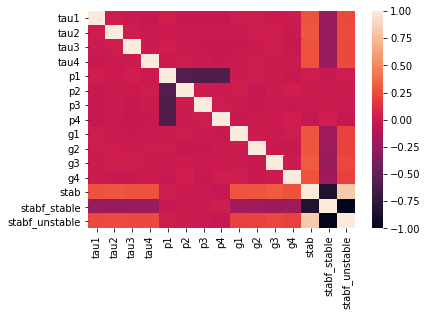

In [52]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)